# DBSCAN



In [2]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (10,10)

In [3]:
def plot(data, labels):
    sns.scatterplot(data[:,0], data[:,1], hue=["Rauschen" if x < 0 else "Cluster {}".format(x) for x in labels]);

Wir erzeugen uns wieder Beispieldaten. Hierbei wählen wir extra verschiedene Dichten für
die Cluster, um das Clustering schwieriger zu machen.

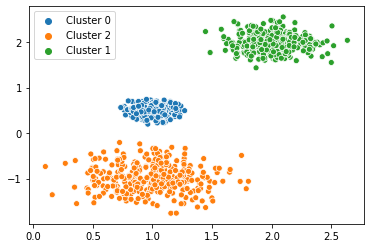

In [4]:

centers = [[1, 0.5], [2, 2], [1, -1]]
stds = [0.1, 0.2, 0.3]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

plot(X, labels_true)


Jetzt setzen wir DBSCAN an, mit den Hyper-Parametern Eps = 0.5 und MinPts = 10:

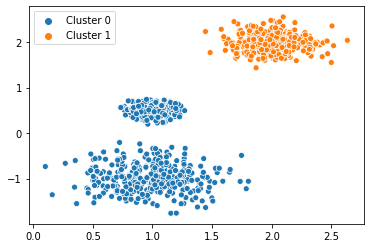

In [5]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=10).fit(X)

plot(X, db.labels_)

## Tuning des Eps Hyper-Parameters

Das Ergebnis oben ist noch nicht gut: Zwei Cluster wurden zu einem verschmolzen.
Lasst uns jetzt eine Reihe von Eps durchprobieren.

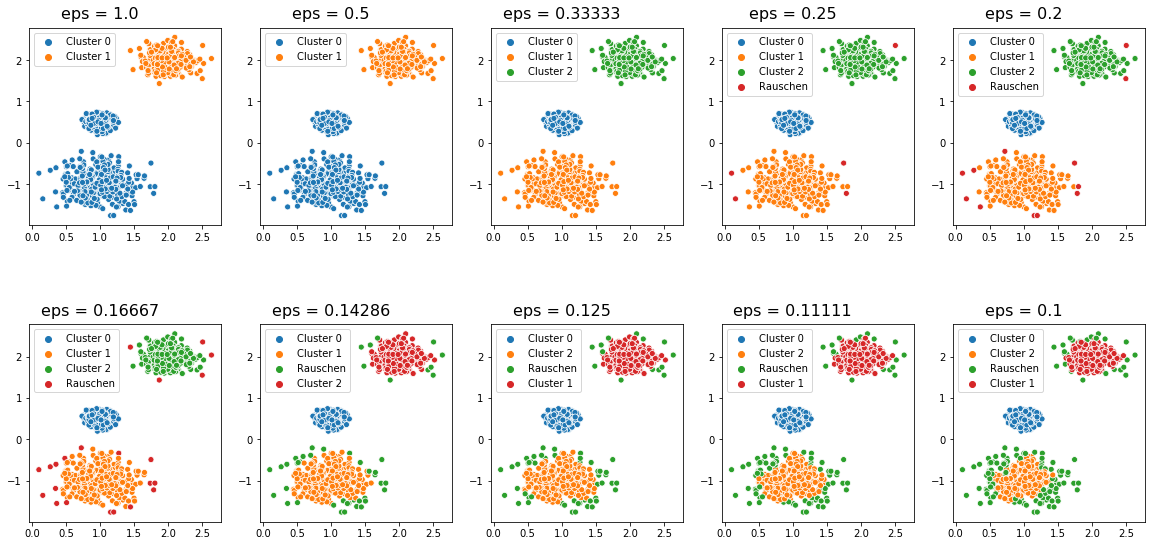

In [6]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(1, 11, 1):
    eps = 1/x
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    ax = fig.add_subplot(4, 5, i)
    ax.text(1, 3, f"eps = {round(eps, 5)}", fontsize=16, ha="center")
    plot(X, db.labels_)

    i += 1


Der gute Bereich für Eps scheint zwischen 0.16 und 0.33 zu liegen.

Kleine Eps führen zu schlecht getrennten zusätzlichen Clustern.
Große Eps trennen eigentlich getrennte Cluster nicht auf.

## Eine systematische Methode, um Eps zu tunen

Um einen Eindruck für ein optimales Eps zu bekommen, müssen wir wissen, wie sich denn
die Anzahl der Punkte innerhalb des Eps-Kreises mit Eps verändert.
Dazu ermitteln wir zu jedem Punkt (bzw. zu einem Sample von 1.000 Punkten) den Radius, den es braucht, damit der Punkt 9 Nachbarn hat.
(9, damit im Kreis zusammen mit dem Punkt 10 Punkte liegen).

Das sortieren wir dann nach aufsteigender Entfernung und schauen, wo sich die Kurve am stärksten ändert.
Dies ist dann unser optimales Eps.

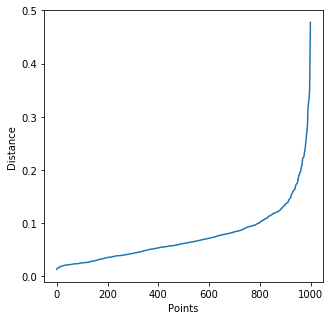

In [7]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=9)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,8], axis=0)
plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance");

"Ellenbogen-Punkte" sind oftmal gute Indikatoren für Schwellen, an denen sich ein Verhalten ändert.

Daher ermitteln wir diesen Punkt jetzt:

In [8]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=100, curve='convex', direction='increasing', interp_method='polynomial')
plt.figure(figsize=(5, 5));
knee.plot_knee();
plt.xlabel("Points")
plt.ylabel("Distance")

eps_knee = distances[knee.knee]
print('Eps am Ellbogenpunkt', eps_knee);

ModuleNotFoundError: No module named 'kneed'

In [ ]:
from IPython.display import Markdown as md
md(f"Der Ellbogen-Punkt ist bei {round(eps_knee,5)}, dies verwenden wir jetzt als Eps:")

In [ ]:
db = DBSCAN(eps=round(eps_knee,5), min_samples=10).fit(X)

plot(X, db.labels_)

## Wie geht DBSCAN mit unseren Halbmonden um?

Wir hatten ja gesehen, dass k-Means bei komplexeren Formen von Clustern versagt.

DBSCAN sollte besser damit umgehen können, probieren wir es aus:

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(200, noise=.05, random_state=0)
db = DBSCAN(eps=eps_knee, min_samples=10).fit(X)

plot(X, db.labels_)

Mit diesen Parametern ist das noch nicht gut.

Die Daten sind weniger dicht als im ersten Beispiel, wir haben viel zu viele als Rauschen klassifizierte Punkte. Daher sollten wir Eps vergrößern (oder min_samples verkleinern).

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

plot(X, db.labels_)

Unsere Struktur hat eine recht gleichmäßige Dichte und die Dichte dazwischen ist Null, daher
erhalten wir schon mit diesem geschätzten Eps ein optimales Ergebnis.

Zum Schluss nehmen wir wieder das "schlechte" Eps und verringern min_samples:

In [ ]:
db = DBSCAN(eps=eps_knee, min_samples=3).fit(X)

plot(X, db.labels_)

Warum hilft uns das nicht richtig weiter?